In [1]:
'''
Portions of this code are adapted from the Hugging Face Diffusers tutorial:
"Train a diffusion model", available at:
https://huggingface.co/docs/diffusers/en/tutorials/basic_training
Licensed under the Apache 2.0 License.

Relevant paper:
Ho, J., Jain, A. and Abbeel, P., 2020. Denoising Diffusion Probabilistic Models. *arXiv preprint arXiv:2006.11239v2* [online]. Available at: <https://doi.org/10.48550/arXiv.2006.11239> [Accessed 9 Sep. 2024].
'''


'\nPortions of this code are adapted from the Hugging Face Diffusers tutorial:\n"Train a diffusion model", available at:\nhttps://huggingface.co/docs/diffusers/en/tutorials/basic_training\nLicensed under the Apache 2.0 License.\n\nRelevant paper:\nHo, J., Jain, A. and Abbeel, P., 2020. Denoising Diffusion Probabilistic Models. *arXiv preprint arXiv:2006.11239v2* [online]. Available at: <https://doi.org/10.48550/arXiv.2006.11239> [Accessed 9 Sep. 2024].\n'


Install:

Import relevant modules


In [2]:
 # Linear Algebra and Science Modules
import numpy as np
import pandas as pd 
import scipy as sp 

# Machine Learning Modules

import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# PSNR takes as input, the true image and the predicted image
# SSIM takes computes the structural similarity between two images, I am going to need to specify 'channel_axis' because the images are not grayscale
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Deep Learning Modules
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from accelerate import notebook_launcher


# Visualisation Tools
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
%matplotlib inline 

# File Loader
import h5py 
import os
from tqdm.auto import tqdm
from pathlib import Path
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hugging face applications
from huggingface_hub import notebook_login, create_repo, HfFolder
from dataclasses import dataclass
import lpips


In [3]:
# Reading the token from the file
with open('hf_token.txt', 'r') as token_file:
    hf_token = token_file.read().strip()

command = f"from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('{hf_token}')"
!python -c "{command}"



In [4]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
@dataclass
class TrainingConfig:
    image_width: int = 192#256 #had to reduce the size to fit in the memory
    image_height: int = 256#384 #had to reduce the size to fit in the memory
    train_batch_size: int = 4 #original ran on 16
    eval_batch_size: int = 4 #original ran on 16
    in_channels: int = 3
    num_epochs: int = 2
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    lr_warmup_steps: int = 500
    save_image_epochs: int = 1
    save_model_epochs: int = 1
    print_loss_curves: int = 1
    mixed_precision: str = "fp16"
    output_dir: str = "depth_conditioned_training_output"
    push_to_hub: bool = True
    hub_model_id: str = "depth_conditioned_training_output"  
    hub_private_repo: bool = True
    overwrite_output_dir: bool = True
    seed: int = 0
    patience: int = 20 # patience for early stopping
    ssim_output: int = 1
    psnr_output: int = 1
    lpips_output = 1
    reconstruction_fixed_timestep: int = 500
    save_sample_images_epochs: int = 1  # New field to control the interval for saving images
    display_images: bool = True  # Optionally display images

config = TrainingConfig()

In [6]:
# Directory containing .mat files
mat_files_dir = 'mixed_data_set'


Custom Dataset Class
Intialization Function:
-inital

# Note

- heapRGBCompositeImage comes as a (3, 640, 480)
- heapDepthImage comes as (640, 480)
- a typical heapDepthImage will have a minimum value of around 0.288 and maximum of inf
- Q - replaced infs with zeros

In [7]:
# Custom Dataset Class
class MatDataset(Dataset):
    def __init__(self, mat_files_dir, transform=None, virtual_size=None):
        self.mat_files_dir = mat_files_dir
        self.transform = transform
        self.file_names = [f for f in os.listdir(mat_files_dir) if f.endswith('.mat')]
        self.virtual_size = virtual_size
        #print(self.file_names)

    def __len__(self):
        if self.virtual_size:
            return self.virtual_size
        else:
            return len(self.file_names)

    def __getitem__(self, idx):
        if self.virtual_size:
            idx = np.random.randint(len(self.file_names))
        mat_file_path = os.path.join(self.mat_files_dir, self.file_names[idx])
        with h5py.File(mat_file_path, 'r') as file:
            heapRGBCompositeImage = np.array(file['heapRGBCompositeImage'])
            heapDepthImage = np.array(file['heapDepthImage'])

        # Replace inf values with zeros before transformation
        heapDepthImage = np.where(np.isinf(heapDepthImage), 0, heapDepthImage)        

        # Ensure heapDepthImage has shape (1, H, W)
        if heapDepthImage.shape[0] != 1:
            heapDepthImage = np.expand_dims(heapDepthImage, axis=0)
            #heapDepthImage = heapDepthImage.unsqueeze(0)


        if self.transform:
            heapRGBCompositeImage = self.transform(heapRGBCompositeImage)
            heapDepthImage = self.transform(heapDepthImage)
        else:
            heapRGBCompositeImage = torch.tensor(heapRGBCompositeImage).float()
            heapDepthImage = torch.tensor(heapDepthImage).float()

        
        # Concatenate RGB and Depth image along the channel dimension
        combined_image = torch.cat((heapRGBCompositeImage, heapDepthImage), dim=0)

        return combined_image

In [8]:
# Custom transform to handle normalization and resizing
class ToTensorCustom:
    def __init__(self, mean_rgb, std_rgb, mean_depth, std_depth):
        self.rgb_transform = transforms.Compose([
            transforms.Resize((config.image_height, config.image_width)),
            transforms.Normalize(mean=mean_rgb, std=std_rgb),
        ])
        self.depth_transform = transforms.Compose([
            transforms.Resize((config.image_height, config.image_width)),
            transforms.Normalize(mean=[mean_depth], std=[std_depth]),
        ])

    def __call__(self, sample):
        if sample.shape[0] == 3:  # RGB image
            return self.rgb_transform(torch.tensor(sample).float())
        elif sample.shape[0] == 1:  # Depth image
            return self.depth_transform(torch.tensor(sample).float())
        else:
            raise ValueError("Unexpected shape of the sample. Expected 3 (RGB) or 1 (Depth) channel.")


In [9]:
# Calculate mean and standard deviation of the dataset
def calculate_mean_std(dataset, batch_size):
    loader = DataLoader(dataset, batch_size, shuffle=False, num_workers=0)  # set number of workers to 0 instead of 4 incase running on windows machine as windows handles multiprocessing differently
    mean_rgb = np.zeros(3)
    mean_depth = 0
    std_rgb = np.zeros(3)
    std_depth = 0
    num_samples_rgb = np.zeros(3)
    num_samples_depth = 0

    for images in loader:
        rgb_images = images[:, :3, :, :].numpy()  # RGB channels
        depth_images = images[:, -1, :, :].numpy()  # Depth channel
        depth_images = np.where(np.isinf(depth_images), 0, depth_images)

        for i in range(3):  # For each RGB channel
            non_zero_pixels = rgb_images[:, i, :, :][rgb_images[:, i, :, :] > 0.1]
            mean_rgb[i] += non_zero_pixels.sum()
            std_rgb[i] += (non_zero_pixels ** 2).sum()
            num_samples_rgb[i] += len(non_zero_pixels)
        
        non_zero_depth_pixels = depth_images[depth_images > 0.1]
        mean_depth += non_zero_depth_pixels.sum()
        std_depth += (non_zero_depth_pixels ** 2).sum()
        num_samples_depth += len(non_zero_depth_pixels)

    mean_rgb /= num_samples_rgb
    std_rgb = np.sqrt(std_rgb / num_samples_rgb - mean_rgb ** 2)
    mean_depth /= num_samples_depth
    std_depth = np.sqrt(std_depth / num_samples_depth - mean_depth ** 2)

    return mean_rgb, std_rgb, mean_depth, std_depth

# Calculate mean and std
dataset = MatDataset(mat_files_dir)
mean_rgb, std_rgb, mean_depth, std_depth = calculate_mean_std(dataset, config.train_batch_size)
print(f"Mean RGB: {mean_rgb}, Std RGB: {std_rgb}")
print(f"Mean Depth: {mean_depth}, Std Depth: {std_depth}")

Mean RGB: [0.34923752 0.34702641 0.3348045 ], Std RGB: [0.18475236 0.1844884  0.17948966]
Mean Depth: 0.42890357555737707, Std Depth: 0.09435119392023937


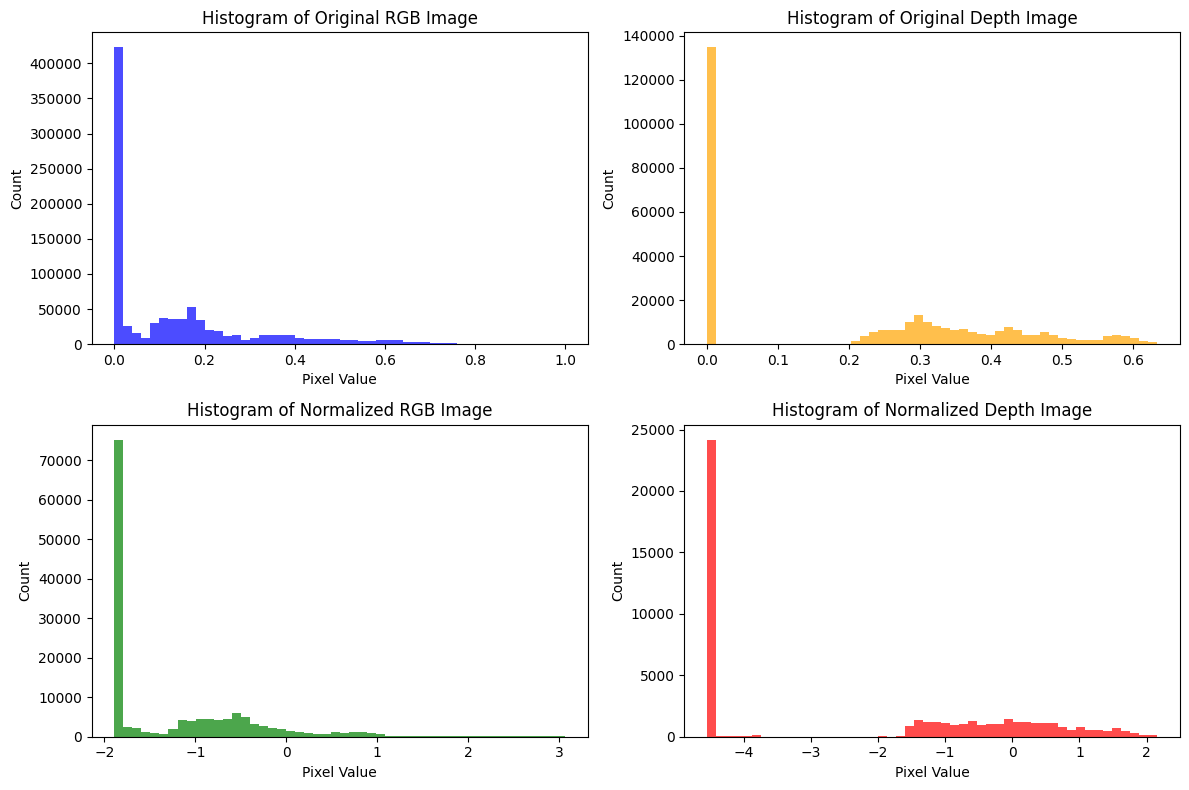

In [10]:
# Load an image without normalization
dataset = MatDataset(mat_files_dir, virtual_size=4*64)
#print(f"Shape of dataset: {dataset}")
original_image = dataset[0]  # Get the first image from the dataset
#print(f"Shape of original data: {original_image.shape}")

# Load an image with normalization
normalized_dataset = MatDataset(mat_files_dir, transform=ToTensorCustom(mean_rgb, std_rgb, mean_depth, std_depth), virtual_size=4*64)
#print(f"Shape of normalized dataset: {normalized_dataset}")
normalized_image = normalized_dataset[0]  # Get the first normalized image
#print(f"Shape of normalized dataset [0]: {normalized_dataset[0]}")

# Convert original and normalized images to numpy for visualization
original_rgb_np = original_image[:3].numpy().flatten()  # Extract RGB channels and flatten to go from 3D tensor to 1 D array
original_depth_np = original_image[3].numpy().flatten()  # Extract depth channel and flatten

normalized_rgb_np = normalized_image[:3].numpy().flatten()  # Extract RGB channels and flatten
normalized_depth_np = normalized_image[3].numpy().flatten()  # Extract depth channel and flatten

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Original RGB Histogram
axs[0, 0].hist(original_rgb_np, bins=50, color='blue', alpha=0.7)
axs[0, 0].set_title('Histogram of Original RGB Image')
axs[0, 0].set_xlabel('Pixel Value')
axs[0, 0].set_ylabel('Count')

# Original Depth Histogram
axs[0, 1].hist(original_depth_np, bins=50, color='orange', alpha=0.7)
axs[0, 1].set_title('Histogram of Original Depth Image')
axs[0, 1].set_xlabel('Pixel Value')
axs[0, 1].set_ylabel('Count')

# Normalized RGB Histogram
axs[1, 0].hist(normalized_rgb_np, bins=50, color='green', alpha=0.7)
axs[1, 0].set_title('Histogram of Normalized RGB Image')
axs[1, 0].set_xlabel('Pixel Value')
axs[1, 0].set_ylabel('Count')

# Normalized Depth Histogram
axs[1, 1].hist(normalized_depth_np, bins=50, color='red', alpha=0.7)
axs[1, 1].set_title('Histogram of Normalized Depth Image')
axs[1, 1].set_xlabel('Pixel Value')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


A dataset is created after transforming .mat files from the set directory.
We find out the size of this dataset.
Mext we perform a 80:20 split of train to validation dataset #could have a test set, flat test across all methods. To avoid emphasising a particular method in the experiments.
Randomly split the datasize based on the training and validation set size.

A data loader, is a python iterable, essentially a function, that allows me to iterate over the dataset.
I am able to specify the dataset to iterate over
I specify the batch size, whether I would like to shuffle
I also specify the number of workers which allows the DataLoader to process multiple data points at a time

I have specified a DataLoader for the train and validation dataset.

I then see what a batch contains, to make sure the data loading works correctly.

I get a random batch and plot this
I plot a maximum of 9 images on a 3x3 grid
MatDataset in this instance returns a concatenanted image of four channels, so I specify what I want to see on the plots showing RGB and the depth image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 4, 256, 192])


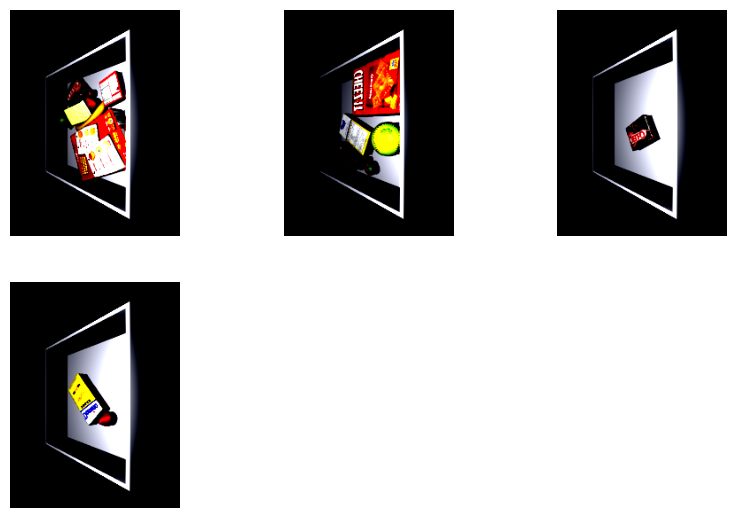

<Figure size 640x480 with 0 Axes>

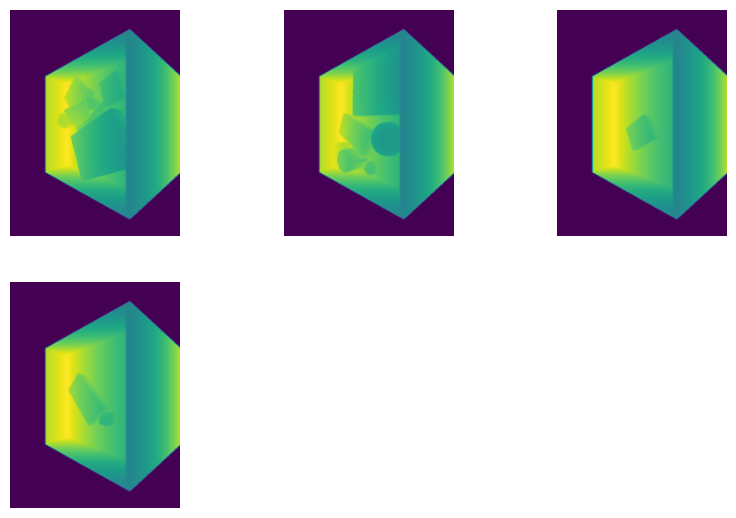

In [11]:
# Create dataset with normalization
normalized_dataset = MatDataset(mat_files_dir, transform=ToTensorCustom(mean_rgb, std_rgb, mean_depth, std_depth), virtual_size=4*64)

# Split dataset into training and validation
train_size = int(0.8 * len(normalized_dataset))
val_size = len(normalized_dataset) - train_size
train_dataset, val_dataset = random_split(normalized_dataset, [train_size, val_size])

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=0) # set number of workers to 0 instead of 4 incase running on windows machine as windows handles multiprocessing differently
val_dataloader = DataLoader(val_dataset, batch_size=config.eval_batch_size, shuffle=False, num_workers=0)

# Check data loading with debugging
for batch in train_dataloader:
    print(batch.shape)
    break

# Visualize a few images to verify
images = next(iter(train_dataloader))

plt.figure(figsize=(10, 10))
for i in range(min(9, images.size(0))):  # Ensure we do not exceed batch size
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy()[:, :, :3])  # Show only RGB channels
    plt.axis('off')
plt.show()

plt.clf()
plt.figure(figsize=(10, 10))
for i in range(min(9, images.size(0))):  # Ensure we do not exceed batch size
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy()[:, :, -1])  # Show the depth channels
    plt.axis('off')
plt.show()

Define the Training Configuration

In [12]:
config.image_height
config.image_width

192

In [13]:
128/32

4.0

In [14]:
# Update the model to accept 4 channels
model = UNet2DModel(
    sample_size=(config.image_height, config.image_width),
    in_channels=4,#4,  # Updated to 4 channels
    out_channels=3,#4,  # Updated to 4 channels
    center_input_sample = True,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512, 1024),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    downsample_type = "resnet",
    upsample_type = "resnet"
)
noise_scheduler = DDPMScheduler(num_train_timesteps=2000)
from diffusers.optimization import get_cosine_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)


In [15]:
plateau_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) #Added reduce on plateau scheduler

# Testing Model and Input Data Fit on GPU

In [16]:
model

UNet2DModel(
  (conv_in): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [17]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.3.1+cu121
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [18]:

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Please check your setup.")


PyTorch Version: 2.3.1+cu121
CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
!nvidia-smi

Mon Sep  9 12:47:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P5              7W /   65W |     667MiB /   8188MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
model = model.to(device)
model.device

device(type='cuda', index=0)

In [22]:
!nvidia-smi

Mon Sep  9 12:47:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P4             10W /   66W |    1885MiB /   8188MiB |     75%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
input_image = np.random.uniform() * torch.ones((config.train_batch_size, config.in_channels+1, config.image_height, config.image_width))
#timestep = torch.randint(0, 2000, (1,))
timestep = torch.randint(0, 2000, (config.train_batch_size,))
input_image.shape, timestep.shape

(torch.Size([4, 4, 256, 192]), torch.Size([4]))

In [24]:
input_image = input_image.to(device)
input_image.device

device(type='cuda', index=0)

In [25]:
!nvidia-smi

Mon Sep  9 12:47:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P4              9W /   68W |    1885MiB /   8188MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
model = model.to(device)
model.device

device(type='cuda', index=0)

In [27]:
input_image.shape
timestep.shape

torch.Size([4])

In [28]:
output = model(input_image.to(device), timestep = timestep.to(device)).sample.shape
output

c:\Users\isaac\anaconda3\envs\my_env\lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


torch.Size([4, 3, 256, 192])

In [29]:
!nvidia-smi

Mon Sep  9 12:47:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   47C    P4             14W /   65W |    7892MiB /   8188MiB |     62%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
new_cols= config.train_batch_size//2

# Preparing for Training and Evaluation

### Evaluation Function:
- Saves and generates images during training or after the training process.
- Takes in `config`, `epoch`, and `pipeline` as input. 
- The `config` contains settings like the batch size and output directory, while the `pipeline` is the image generation pipeline (e.g., diffusion model pipeline).
- The main goal is to generate images based on the validation dataloader and save them as a grid of images.
- Process:
1. It uses the pipeline to generate images. The seed is fixed for reproducibility, ensuring that the same images are generated when the same seed is used.
2. Image Conversion: Once the images are generated, they are converted from arrays into PIL images.
3. Image Grid: A grid of generated images is created using `make_image_grid()`, and this grid is saved as a PNG file.
4. Output Directory: The generated images are saved in the output directory specified in the `config`, making it easy to keep track of generated results for different epochs.


In [31]:
def evaluate(config, epoch, pipeline):
    images = pipeline(batch_size=config.eval_batch_size, generator=torch.manual_seed(config.seed), val_dataloader=val_dataloader).images
    images = [Image.fromarray(np.array(images[i])[:,:, :3]) for i in range(len(images))]
    image_grid = make_image_grid(images, rows=2, cols=new_cols)
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [32]:
def handle_nan(tensor):
    """Replace nan values in the tensor with zero."""
    return torch.where(torch.isnan(tensor), torch.zeros_like(tensor), tensor)

In [33]:
def loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)  # Adjusting epochs to start from 1
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    # plt.plot(train_losses, label="Training Loss")
    # plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [34]:
def calculate_psnr_ssim(clean_images, denoised_images):
    """Calculate PSNR and SSIM for a batch of images, ignoring the depth channel."""
    psnr_scores = []
    ssim_scores = []

    # Extract the RGB channels from clean_images and denoised_images
    clean_rgb_images = clean_images[:, :3, :, :]
    denoised_rgb_images = denoised_images[:, :3, :, :]

    # Calculate data range dynamically based on the RGB channels of clean images
    data_range = clean_rgb_images.max().item() - clean_rgb_images.min().item()

    for i in range(len(clean_rgb_images)): 
        # Convert images from (C, H, W) to (H, W, C) and move to CPU if needed
        clean_image = clean_rgb_images[i].cpu().permute(1, 2, 0).detach().numpy()
        denoised_image = denoised_rgb_images[i].cpu().permute(1, 2, 0).detach().numpy()

        # Calculate PSNR and SSIM between the clean and denoised images
        psnr_score = peak_signal_noise_ratio(clean_image, denoised_image, data_range=data_range)
        ssim_score = structural_similarity(clean_image, denoised_image, channel_axis=2, data_range=data_range)

        psnr_scores.append(psnr_score)
        ssim_scores.append(ssim_score)

    return np.mean(psnr_scores), np.mean(ssim_scores)

# Save Metric graphs

- Responsible for generating and saving plots to show how the metrics evolve over the training epochs
- psnr_scores_epoch is a list/array of PSNR scores collected over the epochs
- it will save at specified output intervals
- Plots the SSIM scores recorded at each epoch
- saves to folder

In [35]:
def save_metric_graphs(all_psnr_scores, all_ssim_scores, all_lpips_scores, epoch, config):
    """Save PSNR, SSIM, and LPIPS graphs if required."""
    #epochs = range(1, len(psnr_scores_epoch) + 1)  # Adjusted to start from 1
    epochs = range(1, epoch + 2)  # Adjusted to start from 1

    # Save SSIM graph
    if (epoch + 1) % config.ssim_output == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, all_ssim_scores, label='SSIM Score')  # Plotting against the integer epoch values
        plt.xlabel('Epoch')
        plt.ylabel('SSIM')
        plt.xticks(epochs)  # Ensuring that the x-axis only shows integer values
        plt.legend()
        plt.title('SSIM vs. Epoch')
        plt.savefig(os.path.join(config.output_dir, f"ssim_vs_epoch_epoch_{epoch}.png"))  # Adjusted to save correctly for the next epoch
        plt.close()

    # Save PSNR graph
    if (epoch + 1) % config.psnr_output == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, all_psnr_scores, label='PSNR Score')  # Plotting against the integer epoch values
        plt.xlabel('Epoch')
        plt.ylabel('PSNR')
        plt.xticks(epochs)  # Ensuring that the x-axis only shows integer values
        plt.legend()
        plt.title('PSNR vs. Epoch')
        plt.savefig(os.path.join(config.output_dir, f"psnr_vs_epoch_epoch_{epoch}.png"))  # Adjusted to save correctly for the next epoch
        plt.close()

    # Save LPIPS graph
    if (epoch + 1) % config.lpips_output == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, [1 - score for score in all_lpips_scores], label='1 - LPIPS Score')  # Plotting against the integer epoch values
        plt.xlabel('Epoch')
        plt.ylabel('1 - LPIPS')
        plt.xticks(epochs)  # Ensuring that the x-axis only shows integer values
        plt.legend()
        plt.title('1 - LPIPS vs. Epoch')
        plt.savefig(os.path.join(config.output_dir, f"lpips_vs_epoch_epoch_{epoch}.png"))  # Adjusted to save correctly for the next epoch
        plt.close()


# Visualise the denoising process of a diffusion model at a fixed timestep

- in eval mode - certain layers like drop out and batch normalization behave differently compared to training mode
- no grad, no need for gradient computation since this is evaluation
- loop over batches provided by the validation data loader
- generate noise tensor
- add noise corresponding to specified timestep using the noise scheduler
- get denoised from model

In [36]:
def visualize_fixed_timestep(config, model, noise_scheduler, val_dataloader, timestep=config.reconstruction_fixed_timestep):
    model.eval()  # we have to ensure the model is in evaluation mode
    
    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            clean_images = batch.to(device)  # Assuming batch contains 4-channel images (RGB + Depth) [batch_size, 4, height, width]
            noise = torch.randn(clean_images[:, :3, :, :].shape, device=clean_images.device)  # Generate noise for RGB channels
            
            # Use the fixed timestep - create the same tensor for every image in the batch
            timesteps = torch.full((clean_images.size(0),), timestep, device=clean_images.device, dtype=torch.int64)
            
            # Add noise to the RGB channels
            noisy_images = noise_scheduler.add_noise(clean_images[:, :3, :, :], noise, timesteps)
            noisy_images = noisy_images.to(device)
            
            # Concatenate the noisy RGB channels with the depth channel
            input_images = torch.cat((noisy_images, clean_images[:, -1:, :, :]), dim=1)  # Shape: [batch_size, 4, height, width]
            
            # Pass the noisy+depth images to the model
            noise_pred = model(input_images, timesteps, return_dict=False)[0]
            denoised_images = noisy_images - noise_pred  # Denoise only the RGB channels
            
            # Visualize the images
            fig, axs = plt.subplots(3, clean_images.size(0), figsize=(15, 7))
            
            for i in range(clean_images.size(0)):
                axs[0, i].imshow(clean_images[i, :3, :, :].permute(1, 2, 0).cpu().detach().numpy())
                axs[0, i].axis('off')
                axs[0, i].set_title(f"Target {i+1}")

                axs[1, i].imshow(noisy_images[i].permute(1, 2, 0).cpu().detach().numpy())
                axs[1, i].axis('off')
                axs[1, i].set_title(f"Noisy {i+1} (Timestep {timestep})")

                axs[2, i].imshow(denoised_images[i].permute(1, 2, 0).cpu().numpy())
                axs[2, i].axis('off')
                axs[2, i].set_title(f"Denoised {i+1}")

            plt.suptitle(f"Denoising at Fixed Timestep {timestep}")
            plt.show()
            break  # Only process the first batch for visualization


In [37]:
def save_and_display_images(clean_images, denoised_images, epoch, config, step="validation"):
    if (epoch + 1) % config.save_sample_images_epochs == 0:
        os.makedirs(config.output_dir, exist_ok=True)
        
        fig, axs = plt.subplots(2, clean_images.size(0), figsize=(15, 5))
        
        for i in range(clean_images.size(0)):
            # Only visualize and save the RGB channels (first 3 channels)
            axs[0, i].imshow(clean_images[i, :3, :, :].permute(1, 2, 0).cpu().detach().numpy())
            axs[0, i].axis('off')
            axs[0, i].set_title(f"TI {i+1}")

            axs[1, i].imshow(denoised_images[i].permute(1, 2, 0).cpu().detach().numpy())
            axs[1, i].axis('off')
            axs[1, i].set_title(f"PI {i+1}") # Predicted Images
        
        plt.suptitle(f"Epoch: {epoch + 1} ({step})")
        plt.savefig(os.path.join(config.output_dir, f"sample_images_epoch_{epoch + 1}.png"))
        
        if config.display_images:
            plt.show()
        plt.close()


In [38]:
# Initialize LPIPS loss functions
loss_fn_alex = lpips.LPIPS(net='alex')  # Best forward scores
loss_fn_alex = loss_fn_alex.to(device)  # Move LPIPS model to the correct device

# Convert RGB images to the [-1, 1] range for LPIPS calculation
def convert_to_lpips_range(image, mean_rgb, std_rgb):
    # Reverse the normalization: (image * std) + mean
    mean_rgb_tensor = torch.tensor(mean_rgb).view(1, 3, 1, 1).to(image.device).float()
    std_rgb_tensor = torch.tensor(std_rgb).view(1, 3, 1, 1).to(image.device).float()
    image = image.float()  # Ensure the image is also in float32
    image = image * std_rgb_tensor + mean_rgb_tensor
    
    # Scale to the [-1, 1] range
    image = 2 * (image - image.min()) / (image.max() - image.min()) - 1
    return image


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\isaac\anaconda3\envs\my_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\isaac\anaconda3\envs\my_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\isaac\anaconda3\envs\my_env\lib\site-packages\lpips\weights\v0.1\alex.pth


In [39]:
# Store losses
train_losses = []
val_losses = []
# Initialize lists to store PSNR and SSIM scores for graphing
all_psnr_scores = []
all_ssim_scores = []
all_lpips_scores = []

### Training Loop :
This training script is designed to train a model using a diffusion process, handling both training and validation data. It incorporates multiple features:
- Mixed Precision & Distributed Training: The script uses Hugging Face’s `Accelerator` to enable distributed training and mixed precision training, which helps reduce memory usage and speed up trainin
- Logging: It logs the training and validation metrics using TensorBoard, which allows tracking model performance during the training process.
- Training and Validation Loops: The training loop handles noise prediction and loss computation using the diffusion process, while the validation loop evaluates the model’s performance on the validation dataset.
- Gradient Accumulation: The script uses gradient accumulation to allow the use of larger batch sizes, effectively updating gradients after a defined number of steps.
- Learning Rate Schedulers: The script dynamically adjusts the learning rate during training using schedulers.
- Image Generation: At regular intervals, the model generates images based on the validation data for qualitative assessment.
- Early Stopping: If the model doesn’t improve for a predefined number of epochs, early stopping is triggered to prevent overfitting and save computation time.

Main steps in the Training Loop:
1. Initialize Accelerator: Handles multi-GPU or TPU environments, and enables mixed precision.
2. Prepare Model and Optimizer: Wrapping the model and optimizer with `accelerator.prepare()` prepares them for distributed training.
3. Main Training Loop: In each epoch, the model is trained using batches of data, where noisy images are generated, and the model tries to predict the noise.
4. Validation Loop: After each epoch, the model is evaluated using the validation dataset. Key metrics like loss, PSNR, SSIM, and LPIPS are calculated and logged.
5. Image Generation and Checkpoints: At predefined intervals, the model generates images for evaluation, and model checkpoints are saved.
 
Learning Rate Scheduling and Early Stopping:
- A plateau scheduler reduces the learning rate if validation loss stops improving.
- Early stopping halts training if the model doesn't improve after a specified number of epochs.


Launching training on one GPU.


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

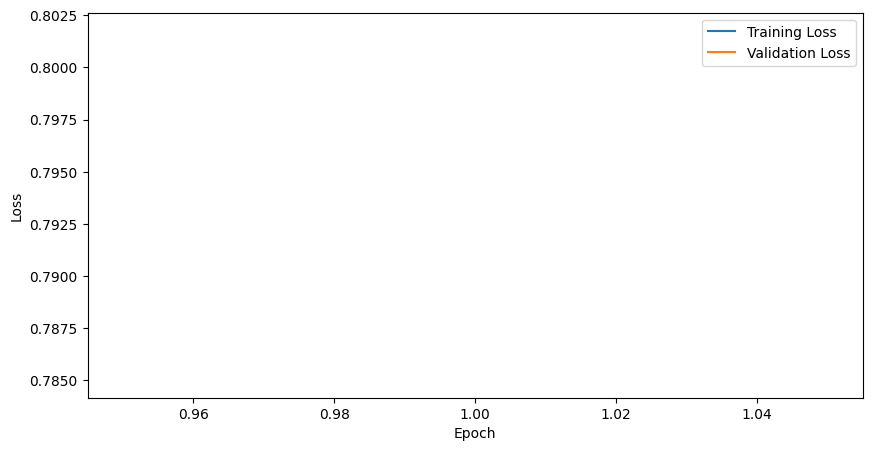

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1725882472.MSI.27904.0:   0%|          | 0.00/6.28k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


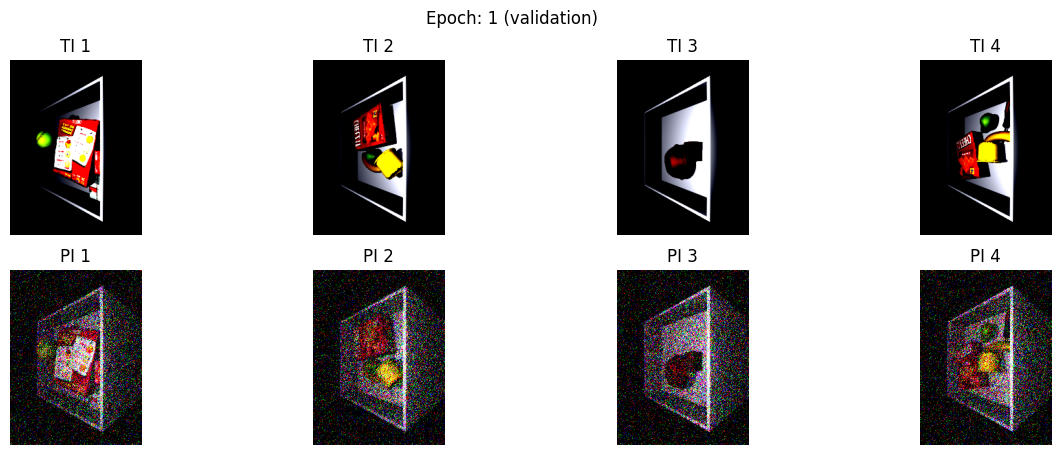

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

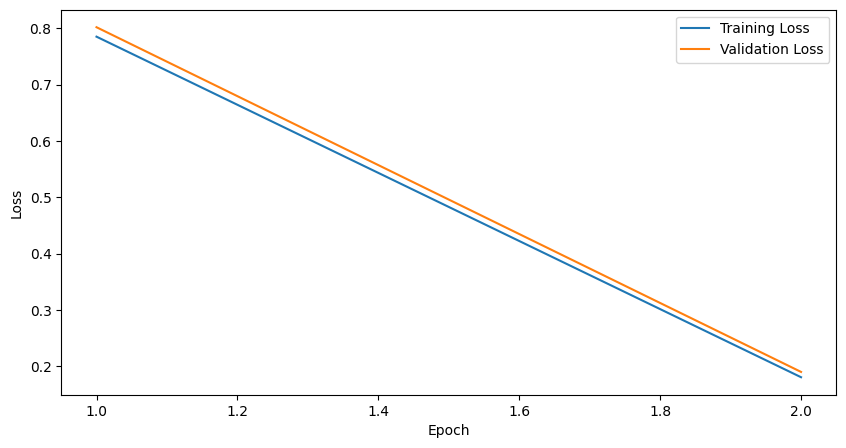

  0%|          | 0/1000 [00:00<?, ?it/s]

events.out.tfevents.1725882472.MSI.27904.0:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

c:\Users\isaac\anaconda3\envs\my_env\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\isaac\.cache\huggingface\hub\models--IsaacAkintaro--depth_conditioned_training_output. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


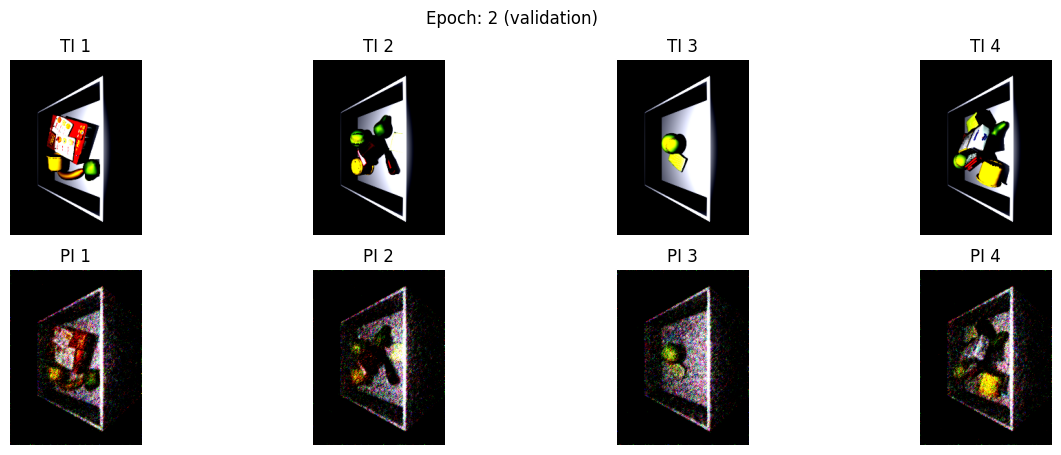

In [40]:
# Added early stopping to the training loop
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, val_dataloader, lr_scheduler, plateau_scheduler):
    # Initialize an empty DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'learning_rate', 'psnr', 'ssim', 'lpips'])
    #create accelerator instance to handle distributed training, mixed precision training and logging with tensorboard
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    # create output directory if it does not exist
    # push the output directory to the huggingface hub if push_to_hub is set to True
    # intiialise trackers for tensorboard logging
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # preparation for distributed training using accelerator
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    model.to(device)  ### Ensure model is on the correct device

    
    
    global_step = 0 # intialise counter for total number of steps taken during training
    best_loss = float('inf') # intialise best_loss to infinity to track the best loss for early stopping
    epochs_no_improve = 0 # counter for epochs withou improvement in validation loss

    # main training loop
    # for each epoch, set up progress bars for training and validation
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch+1}")

        progress_bar_2 = tqdm(total=len(val_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar_2.set_description(f"Epoch {epoch+1}")

        # Training loop
        model.train()  # Set model to training mode
        for step, batch in enumerate(train_dataloader): # Iterate over the training DataLoader
            clean_images = batch.to(device)  # Move batch to the correct device, these are clean images we will add noise to
            noise = torch.randn(clean_images[:,:3,:,:].shape, device=clean_images.device) # Generate noise tensor
            model = model.to(device) # Ensure model is in the correct device
            bs = clean_images.shape[0] # Get batch size
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64)
            # add noise to the clean images, the first three channels of clean images based on the noise scheduler
            noisy_images = noise_scheduler.add_noise(clean_images[:,:3,:,:], noise, timesteps)
            noisy_images = noisy_images.to(device) # Move noisy images to the correct device
            # concatenate the noisy images with the depth images
            input_images = torch.cat((noisy_images, batch[:,-1,:,:].unsqueeze(1).to(device)), dim=1)
            #input_images = noisy_images

            with accelerator.accumulate(model):
                noise_pred = model(input_images, timesteps, return_dict=False)[0] # Get the noise prediction from the model
                noise_pred = handle_nan(noise_pred) # Replace nan values with zero in the noise prediction
                noise = handle_nan(noise) # Replace nan values with zero in the noise tensor
                loss = F.mse_loss(noise_pred, noise) # Compute the mean squared error loss between the noise prediction and the noise tensor
                accelerator.backward(loss) # Compute the gradients

                accelerator.clip_grad_norm_(model.parameters(), 1.0) # Clip the gradients to prevent exploding gradients
                optimizer.step() # Update the model parameters
                lr_scheduler.step() # Update the learning rate
                optimizer.zero_grad() # Zero the gradients

            # Log the loss and learning rate to the progress bar and tensorboard
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "epoch": epoch}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=epoch)
            global_step += 1

        train_losses.append(loss.item()) # Append the training loss
        # Validation loop
        model.eval()  ### Set model to evaluation mode so that parameters are fixed
        val_loss = 0.0
        psnr_scores_epoch = []
        ssim_scores_epoch = []
        lpips_scores_epoch = []
        with torch.no_grad():  ### Disable gradient computation
            for step, batch in enumerate(val_dataloader):
                clean_images = batch.to(device) # take clean images from batch
                noise = torch.randn(clean_images[:,:3,:,:].shape, device=clean_images.device) # generate noise tensor
                bs = clean_images.shape[0] # get batch size
                model = model.to(device) #ensure model is in correct device
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64)
                noisy_images = noise_scheduler.add_noise(clean_images[:,:3,:,:], noise, timesteps)
                noisy_images = noisy_images.to(device)
                input_images = torch.cat((noisy_images, batch[:,-1, :, :].unsqueeze(1).to(device)), dim=1)
                #input_images = noisy_images
                noise_pred = model(input_images, timesteps, return_dict=False)[0]
                noise_pred = handle_nan(noise_pred)
                noise = handle_nan(noise)
                loss = F.mse_loss(noise_pred, noise)
                val_loss += loss.item() # accumulate the validation loss to compute the average later, we don't need to accumulate for training as we use immediately to update the model

                # Fixed timestep for PSNR and SSIM calculation
                fixed_timesteps = torch.full((clean_images.size(0),), config.reconstruction_fixed_timestep, device=clean_images.device, dtype=torch.int64)
                noise_fixed = torch.randn(clean_images[:, :3, :, :].shape, device=clean_images.device)  # Generate noise for RGB channels
                noisy_images_fixed = noise_scheduler.add_noise(clean_images[:, :3, :, :], noise_fixed, fixed_timesteps)
                noisy_images_fixed = noisy_images_fixed.to(device)

                # Denoise the noisy images
                noise_pred_fixed = model(torch.cat((noisy_images_fixed, batch[:, -1, :, :].unsqueeze(1).to(device)), dim=1), fixed_timesteps, return_dict=False)[0]
                denoised_images = noisy_images_fixed - noise_pred_fixed  # Denoise only the RGB channels

                # Calculate PSNR and SSIM for the fixed timestep
                psnr, ssim = calculate_psnr_ssim(clean_images, denoised_images) #psnr and ssim across the batch
                psnr_scores_epoch.append(psnr) # all the psnr scores for the epoch from each batch
                ssim_scores_epoch.append(ssim) # all the ssim scores for the epoch from each batch

                # Calculate LPIPS for the fixed timestep
                # Convert images back to [-1, 1] range for LPIPS calculation
                clean_images_normalized = convert_to_lpips_range(clean_images[:, :3, :, :], mean_rgb, std_rgb).to(device).float()
                denoised_images_normalized = convert_to_lpips_range(denoised_images, mean_rgb, std_rgb).to(device).float()

                # Calculate LPIPS
                lpips_score = loss_fn_alex(clean_images_normalized, denoised_images_normalized).mean().item()
                lpips_scores_epoch.append(lpips_score)  # Append LPIPS score for the epoch


        val_loss /= len(val_dataloader)  # Compute the average validation loss
        avg_psnr = np.mean(psnr_scores_epoch) # calculate the average psnr score for the epoch
        avg_ssim = np.mean(ssim_scores_epoch) # calculate the average ssim score for the epoch
        avg_lpips = np.mean(lpips_scores_epoch)  # Calculate the average LPIPS score for the epoch
        all_psnr_scores.append(avg_psnr) # append the average psnr score to the list
        all_ssim_scores.append(avg_ssim) # append the average ssim score to the list
        all_lpips_scores.append(avg_lpips)  # Append the average LPIPS score to the list
        val_losses.append(val_loss) # Append the validation loss

        # Append the metrics to the DataFrame
        new_row = pd.DataFrame([{
            'epoch': epoch + 1,
            'train_loss': train_losses[-1],  # Last recorded training loss for the epoch
            'val_loss': val_loss,
            'learning_rate': lr_scheduler.get_last_lr()[0],  # Current learning rate
            'psnr': avg_psnr,
            'ssim': avg_ssim,
            'lpips': avg_lpips
        }])

        # Concatenate the new row with the existing DataFrame
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the metrics DataFrame after each epoch
        metrics_df.to_csv(os.path.join(config.output_dir, 'training_metrics.csv'), index=False)

        logs = {"val_loss": val_loss, "psnr": avg_psnr, "ssim": avg_ssim, "lpips": avg_lpips}  # Log validation loss and metrics
        progress_bar_2.set_postfix(**logs)  # Update progress bar with validation loss
        accelerator.log(logs, step=epoch)  # Log validation loss to tracker

        # Apply learning rate scheduler and check for early stopping
        plateau_scheduler.step(val_loss)  # Use validation loss for plateau scheduler
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        # Check if early stopping condition is met, which is the patience I defined in the training config
        if epochs_no_improve == config.patience:
            print("Early stopping triggered")
            break

        if (epoch + 1) % config.print_loss_curves == 0:
            loss_curves(train_losses, val_losses)
            

        # Log the model and samples to tensorboard and save the model and samples
        if accelerator.is_main_process: # ensure only the main process logs the model and samples
            # intialise the pipeline with the model and noise scheduler for generating samples
            #  unwraps the model from the accelerator to get the original model (without the distributed training wrapper)
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            # evaluate the model and save the samples at specified intervals (the number of epochs you specified in the training config minus 1)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            # same as above but for saving the pipeline (model and scheduler) to hugginface hub and/or local directory instead of evaluating
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(repo_id=repo_id, folder_path=config.output_dir, commit_message=f"Epoch {epoch+1}", ignore_patterns=["step_*", "epoch_*"])
                    pipeline.save_pretrained(config.output_dir, push_to_hub=config.push_to_hub)
                else:
                    pipeline.save_pretrained(config.output_dir)
        # Save and plot metrics graphs after each epoch
        save_metric_graphs(all_psnr_scores, all_ssim_scores, all_lpips_scores, epoch, config)
        # Save and display the images being evaluated
        save_and_display_images(clean_images, denoised_images, epoch, config, step="validation")
    # After training, save the final metrics DataFrame
    metrics_df.to_csv(os.path.join(config.output_dir, 'training_metrics.csv'), index=False)
# prepare the arguments to be passed to the training loop
args = (config, model, noise_scheduler, optimizer, train_dataloader, val_dataloader, lr_scheduler, plateau_scheduler)  # Added val_dataloader

# launch the training loop function with the specified arguments, runs with single process
notebook_launcher(train_loop, args, num_processes=1)

[14.100444364940024, 16.4803468817501]
2
[0.08990943, 0.26798093]
2


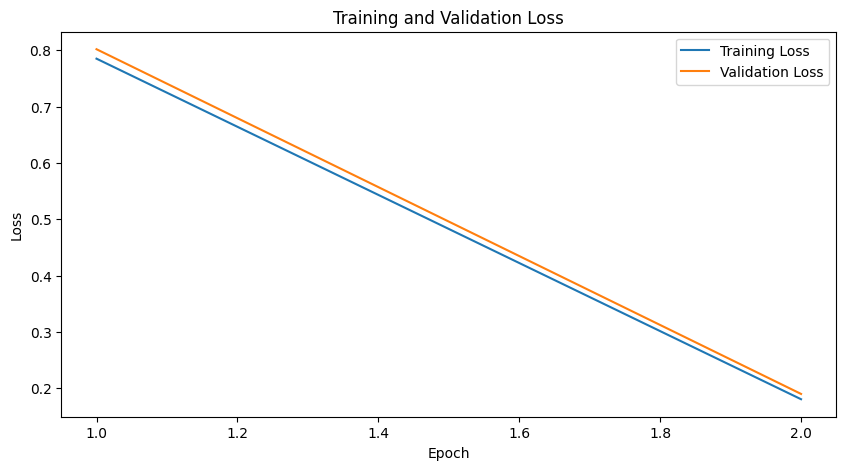

In [41]:
print(all_psnr_scores)
print(len(all_psnr_scores))
print(all_ssim_scores)
print(len(all_ssim_scores))
#  Visualize the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plot_path = os.path.join(config.output_dir, 'training_validation_loss.png')
plt.savefig(plot_path)

plt.show()
